In [1]:
from spectralnet import SpectralNet
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import os
import matplotlib.pyplot as plt
#import holidays
import json
#import seaborn as sns
import pandas as pd
import numpy as np
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from blitz.modules import BayesianLSTM
# from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from collections import Counter

In [2]:
def winkler_score_and_coverage(bootstrap_df, observed_values, CIs):
    results = {}
    
    for CI in CIs:
        CI = CI / 100
        l_alpha = (1 - CI) / 2
        u_alpha = 1 - l_alpha
        alpha_inv = 1 / (1 - CI)
        
        l_percentile = bootstrap_df.quantile(l_alpha)
        u_percentile = bootstrap_df.quantile(u_alpha)
        
        observed_values = np.array(observed_values)

        lower_mask = observed_values <= l_percentile
        middle_mask = (observed_values > l_percentile) & (observed_values < u_percentile)
        upper_mask = observed_values >= u_percentile

        winkler_array = np.zeros(len(l_percentile))
        
        winkler_array[lower_mask] = (u_percentile[lower_mask] - l_percentile[lower_mask]) + 2 * alpha_inv * (l_percentile[lower_mask] - observed_values[lower_mask])
        winkler_array[middle_mask] = (u_percentile[middle_mask] - l_percentile[middle_mask])
        winkler_array[upper_mask] = (u_percentile[upper_mask] - l_percentile[upper_mask]) + 2 * alpha_inv * (observed_values[upper_mask] - u_percentile[upper_mask])
        
        coverage_probability = np.mean(middle_mask)
        winkler_score = np.mean(winkler_array)
        results[CI * 100] = {
            'winkler_scores': winkler_score,
            'coverage_probability': coverage_probability + 0.01
        }
    
    return results

def find_closest_centroid(vector, centroids):
    # Calculate Euclidean distance between the vector and each centroid
    distances = np.linalg.norm(centroids - vector, axis=1)
    
    # Find the index of the centroid with the minimum distance
    closest_centroid_index = np.argmin(distances)
    
    # Return the closest centroid and its index
    closest_centroid = centroids[closest_centroid_index]
    
    return closest_centroid, closest_centroid_index

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
def calculate_metrics(model, X_train_scaled, y_train, X_test_scaled, y_test, y_scaler):
    # Predictions on training data
    train_pred = model.predict(X_train_scaled)
    train_pred_inverse = y_scaler.inverse_transform(train_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics for training data
    train_mape = np.mean(np.abs((y_train - train_pred_inverse) / y_train)) * 100
    train_mse = mean_squared_error(y_train, train_pred_inverse)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_pred_inverse)
    
    # Predictions on testing data
    test_pred = model.predict(X_test_scaled)
    test_pred_inverse = y_scaler.inverse_transform(test_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics for testing data
    test_mape = np.mean(np.abs((y_test - test_pred_inverse) / y_test)) * 100
    test_mse = mean_squared_error(y_test, test_pred_inverse)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_pred_inverse)
    
    # Print results
    print(f"Train MAPE: {train_mape:.2f}")
    print(f"Train MAE:  {train_mae:.2f}")
    print(f"Train MSE:  {train_mse:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test MAPE:  {test_mape:.2f}")
    print(f"Test MAE:   {test_mae:.2f}")
    print(f"Test MSE:   {test_mse:.2f}")
    print(f"Test RMSE:  {test_rmse:.2f}")
    
    # Return results in a dictionary
    return {
        'train_mape': train_mape,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'test_mape': test_mape,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse
    }

In [5]:
train_data = pd.read_csv("train_2021.xls")
test_data = pd.read_csv("test_2022.xls")

In [6]:
train_data.head()

,4741,6406,3461,11141,4746,8976,1681,10646,8731,4766,...,dayofweek,quarter,year,date,holiday,temp,power_lag_1_day,power_lag_2_day,power_lag_3_day,power_lag_4_day
0,0.169647,0.107579,0.157667,0.594056,0.086125,0.084048,0.45170,0.307812,0.33000,0.144389,...,4,1,2021,2021-01-01,1.0,39.6,14.304084,16.661213,14.061251,14.457537
1,0.227882,0.124947,0.125810,0.269333,0.103313,0.088190,0.26860,0.229750,0.30995,0.262444,...,4,1,2021,2021-01-01,1.0,39.6,18.562497,16.357651,14.089020,17.643629
2,0.217412,0.145421,0.114714,0.189278,0.112875,0.086905,0.17150,0.156188,0.30705,0.183944,...,4,1,2021,2021-01-01,1.0,47.1,14.834715,17.817184,15.585964,17.151688
3,0.296000,0.150526,0.128524,0.214944,0.102875,0.240286,0.27260,0.270562,0.32670,0.373333,...,4,1,2021,2021-01-01,1.0,47.7,14.810197,19.168995,17.243200,15.005697
4,0.171235,0.143526,0.207714,0.203667,0.086563,0.197571,0.28285,0.167750,0.34220,0.336611,...,4,1,2021,2021-01-01,1.0,52.5,15.878352,17.201496,19.375538,13.219524


In [7]:
daily_power = np.array(train_data["total_power"]).reshape(365, 96)
daily_power_df = pd.DataFrame(daily_power)
daily_temp = np.array(train_data["temp"]).reshape(365, 96)
daily_temp_df = pd.DataFrame(daily_temp)
# Calculate correlations
correlations = {col: daily_power_df[col].corr(daily_temp_df[col]) for col in daily_temp_df.columns}

In [8]:
# correlations.values()

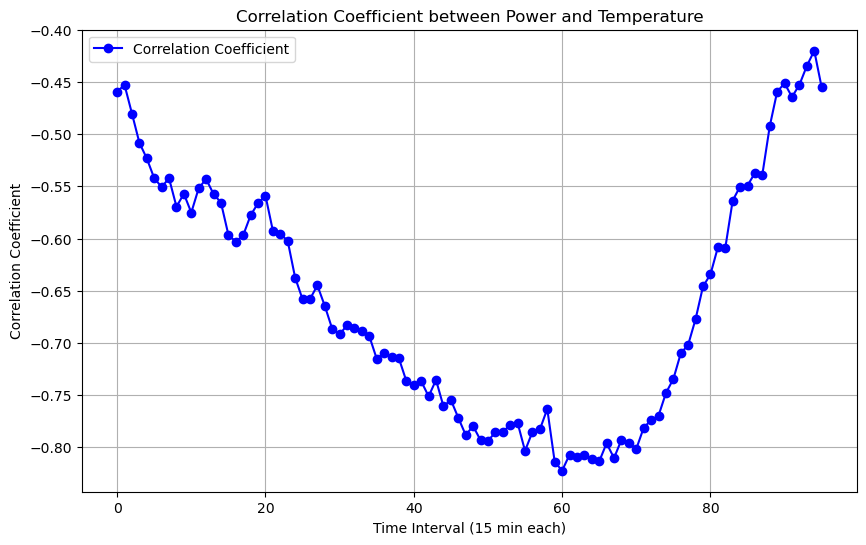

In [9]:
# Plot the Correlation Coefficients
plt.figure(figsize=(10, 6))
plt.plot(correlations.values(), marker='o', linestyle='-', color='b', label='Correlation Coefficient')
plt.title('Correlation Coefficient between Power and Temperature')
plt.xlabel('Time Interval (15 min each)')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
daily_power_tensor = torch.tensor(np.array(daily_power_df), dtype=torch.float32)
daily_temp_tensor = torch.tensor(np.array(daily_temp_df), dtype=torch.float32)

In [11]:
start_time = time.time()
spectralnet = SpectralNet(
        n_clusters=8,
        should_use_ae=True,
        should_use_siamese=True,
        spectral_epochs=100,
        spectral_is_local_scale=False,
        spectral_n_nbg=8,
        spectral_scale_k=3,
        spectral_lr=1e-4,
        spectral_hiddens=[128,128, 8],
    )
spectralnet.fit(daily_power_tensor) # X is the dataset and it should be a torch.Tensor
cluster_assignments = spectralnet.predict(daily_power_tensor) # Get the final assignments to clusters
embeddings = spectralnet.embeddings_
print(time.time()-start_time)
# # Specify the file name
file_name = 'embeddings_2.csv'

# Save the array to a CSV file
np.savetxt(file_name, embeddings, delimiter=',', fmt='%f')

print(f'Array saved to {file_name}')

Embedding data ...
Training SpectralNet:


Train Loss: 3.2166126, Valid Loss: 3.9654987, LR: 0.000000: 100%|██████████| 100/100 [00:02<00:00, 49.94it/s]


3.097445011138916
Array saved to embeddings_2.csv


In [12]:
#read embeddings from the saved file
saved_embeddings = pd.read_csv("embeddings.csv", header=None)
saved_embeddings = saved_embeddings.to_numpy()

In [13]:
# Number of clusters
n_clusters = 4
dim1 = 1
dim2 = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(saved_embeddings)

# Get cluster labels
labels = kmeans.labels_

# Get cluster centers
centers = kmeans.cluster_centers_
# Count the frequency of elements
frequency = Counter(labels)
# print(frequency)

Counter({3: 112, 0: 95, 1: 93, 2: 65})


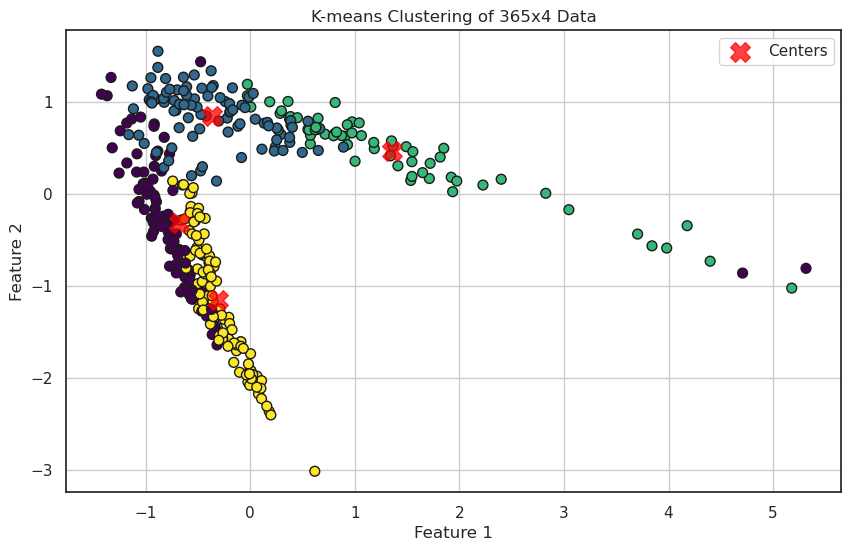

In [73]:

##########################################################################################################################

plt.figure(figsize=(10, 6))

# Scatter plot of the data points
plt.scatter(saved_embeddings[:,dim1], saved_embeddings[:,dim2], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Mark the cluster centers
plt.scatter(centers[:, dim1], centers[:, dim2], c='red', s=200, alpha=0.75, marker='X', label='Centers')

plt.title('K-means Clustering of 365x4 Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# centers

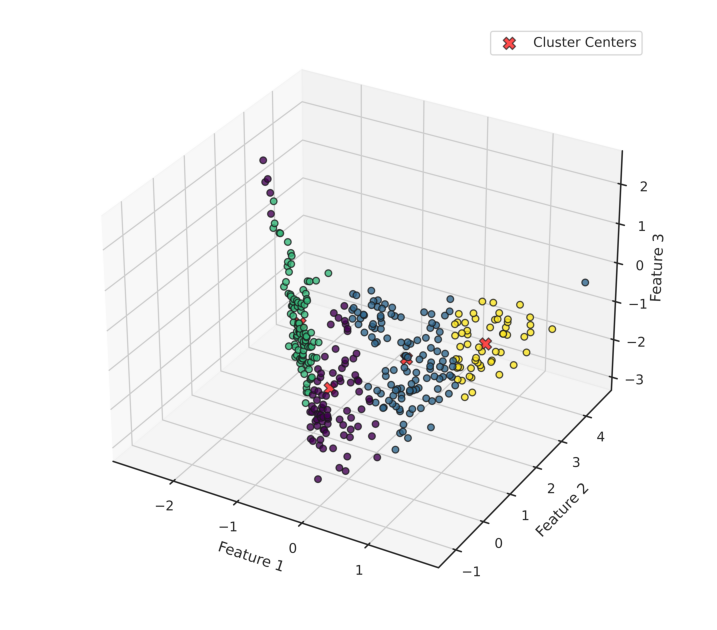

In [82]:
np.random.seed(42)

# Set seaborn style
sns.set(style="white")

# Dimensions to visualize
dim1, dim2, dim3 = 1, 4, 2

# Create the 3D scatter plot
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points
sc = ax.scatter(
    saved_embeddings[:, dim1], saved_embeddings[:, dim2], saved_embeddings[:, dim3],
    c=labels, cmap='viridis', marker='o', edgecolor='k', s=30, alpha=0.8
)

# Scatter plot of cluster centers
ax.scatter(
    centers[:, dim1], centers[:, dim2], centers[:, dim3],
    c='red', s=100, alpha=0.7, marker='X', label='Cluster Centers', edgecolor='k'
)

# Axis labels with larger font
ax.set_xlabel(f'Feature {dim1}', fontsize=12, labelpad=5)
ax.set_ylabel(f'Feature {dim2}', fontsize=12, labelpad=5)
ax.set_zlabel(f'Feature {dim3}', fontsize=12, labelpad=0)

# Legend
ax.legend(loc='upper right', fontsize=11)

# Improve layout
plt.tight_layout()

# Save at high resolution
plt.savefig("embedding_cluster.png", dpi=700)#, bbox_inches='tight')

# Show plot
plt.show()

In [14]:
daily_power_df["label"] = labels

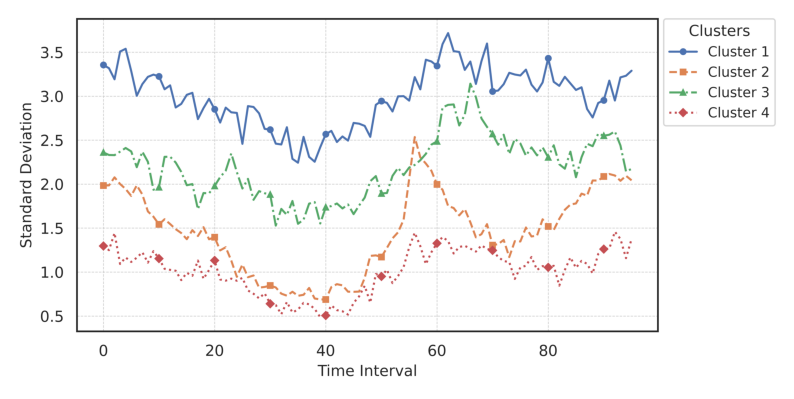

In [85]:
# Compute standard deviation for each cluster
stand_dev = {}
for i in range(4):
    stand_dev[i] = daily_power_df.loc[daily_power_df["label"] == i, range(0, 96)].std()

# Define plotting styles (good for grayscale printing too)
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

# Create figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot each cluster
for i, (key, value) in enumerate(stand_dev.items()):
    ax.plot(
        value.values, label=f'Cluster {key + 1}',
        linewidth=1.5, linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)], markevery=10, markersize=4
    )

# Axis labels
ax.set_xlabel('Time Interval', fontsize=11)
ax.set_ylabel('Standard Deviation', fontsize=11)

# Legend formatting
ax.legend(
    title='Clusters', fontsize=10, title_fontsize=11,
    loc='upper left', bbox_to_anchor=(1.01, 1.0), borderaxespad=0
)

# Grid for readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ticks
ax.tick_params(axis='both', labelsize=11)

# Tight layout for saving
plt.tight_layout()

# Save the figure (high resolution)
plt.savefig("Cluster_Residual_Stdev.png", dpi=700, bbox_inches='tight')

# Show the plot
plt.show()

### ML training

In [15]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

In [16]:
train_data.columns

Index(['4741', '6406', '3461', '11141', '4746', '8976', '1681', '10646',
       '8731', '4766', '9121', '9251', '4771', '10406', '10536', '4521',
       '8746', '10411', '4786', '10421', '11061', '6966', '8761', '10811',
       '9916', '1726', '11071', '8641', '6471', '6986', '9291', '9421',
       '10706', '851', '6356', '4696', '4441', '4576', '4706', '4196', '4201',
       '1001', '11116', '4461', '751', '8816', '4721', '759', '1016', '10746',
       'total_power', 'month', 'day', 'hour', 'minute', 'dayofweek', 'quarter',
       'year', 'date', 'holiday', 'temp', 'power_lag_1_day', 'power_lag_2_day',
       'power_lag_3_day', 'power_lag_4_day'],
      dtype='object')

In [17]:
# Step 1: Prepare the Data
X_train = train_data[['hour', 'minute', 'quarter','holiday', 'temp', 'power_lag_1_day', 'power_lag_2_day','power_lag_3_day', 'power_lag_4_day']]
y_train = train_data['total_power']

X_test = test_data[['hour', 'minute', 'quarter','holiday', 'temp', 'power_lag_1_day', 'power_lag_2_day','power_lag_3_day', 'power_lag_4_day']]
y_test = test_data['total_power']

In [18]:
# Step 2: Scale the Data
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [19]:
# Step 3: Train the Models
start = time.time()

# Linear Regression with Ridge regularization (L2)
ridge = Ridge(alpha=0.7)  
ridge.fit(X_train_scaled, y_train_scaled.flatten())
print(time.time()-start)

# # Random Forest Regressor
# rf = RandomForestRegressor()
# rf.fit(X_train_scaled, y_train_scaled.flatten())
# print(time.time()-start)

0.002724170684814453


In [20]:
gbr = GradientBoostingRegressor()
gbr_param_grid = {
    'n_estimators': [75, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}
gbr_grid_search = GridSearchCV(gbr, gbr_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

start =  time.time()
gbr_grid_search.fit(X_train_scaled, y_train_scaled.flatten())
best_gbr = gbr_grid_search.best_estimator_
print(time.time()-start)

15.72981595993042


In [21]:
# Define the LGBM model
lgbm = LGBMRegressor(verbosity=-1)

# Define parameter grid
lgbm_param_grid = {
    'n_estimators': [50, 75],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 10, 15],
    # 'num_leaves': [20, 50],
    #'min_child_samples': [10, 20]
}

# Perform grid search
lgbm_grid_search = GridSearchCV(
    lgbm,
    lgbm_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)
start =  time.time()
# Fit the model
lgbm_grid_search.fit(X_train_scaled, y_train_scaled.flatten())

# Best estimator
best_lgbm = lgbm_grid_search.best_estimator_
print("Training Time:", time.time() - start)

Training Time: 29.769200563430786


In [22]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Ridge Regression
ridge_train_pred = ridge.predict(X_train_scaled)
ridge_train_pred_inverse = y_scaler.inverse_transform(ridge_train_pred.reshape(-1, 1)).flatten()

ridge_test_pred = ridge.predict(X_test_scaled)
ridge_test_pred_inverse = y_scaler.inverse_transform(ridge_test_pred.reshape(-1, 1)).flatten()

# Gradient Boosting Regressor
gbr_train_pred = best_gbr.predict(X_train_scaled)
gbr_train_pred_inverse = y_scaler.inverse_transform(gbr_train_pred.reshape(-1, 1)).flatten()

gbr_test_pred = best_gbr.predict(X_test_scaled)
gbr_test_pred_inverse = y_scaler.inverse_transform(gbr_test_pred.reshape(-1, 1)).flatten()

# LGBM Predictions
lgbm_train_pred = best_lgbm.predict(X_train_scaled)
lgbm_train_pred_inverse = y_scaler.inverse_transform(lgbm_train_pred.reshape(-1, 1)).flatten()

lgbm_test_pred = best_lgbm.predict(X_test_scaled)
lgbm_test_pred_inverse = y_scaler.inverse_transform(lgbm_test_pred.reshape(-1, 1)).flatten()

# # Ridge Regression
# ridge_train_pred = ridge.predict(X_train_scaled)
# ridge_train_pred_inverse = y_scaler.inverse_transform(ridge_train_pred.reshape(-1, 1)).flatten()


# ridge_test_pred = ridge.predict(X_test_scaled)
# ridge_test_pred_inverse = y_scaler.inverse_transform(ridge_test_pred.reshape(-1, 1)).flatten()


# # Gradient Boosting Regressor
# gbr_train_pred = gbr.predict(X_train_scaled)
# gbr_train_pred_inverse = y_scaler.inverse_transform(gbr_train_pred.reshape(-1, 1)).flatten()


# gbr_test_pred = gbr.predict(X_test_scaled)
# gbr_test_pred_inverse = y_scaler.inverse_transform(gbr_test_pred.reshape(-1, 1)).flatten()



In [58]:
ridge_metrics = calculate_metrics(ridge, X_train_scaled, y_train, X_test_scaled, y_test, y_scaler)
gbr_metrics = calculate_metrics(best_gbr, X_train_scaled, y_train, X_test_scaled, y_test, y_scaler)
lgbm_metrics = calculate_metrics(best_lgbm, X_train_scaled, y_train, X_test_scaled, y_test, y_scaler)

# Combine results into a DataFrame including MAE
metrics_df = pd.DataFrame({
    'Model': ['Ridge Regression', 'Gradient Boosting Regressor', 'LGBM'],
    'Train MAPE': [ridge_metrics['train_mape'], gbr_metrics['train_mape'], lgbm_metrics['train_mape']],
    'Train MAE':  [ridge_metrics['train_mae'], gbr_metrics['train_mae'], lgbm_metrics['train_mae']],
    'Train MSE':  [ridge_metrics['train_mse'], gbr_metrics['train_mse'], lgbm_metrics['train_mse']],
    'Train RMSE': [ridge_metrics['train_rmse'], gbr_metrics['train_rmse'], lgbm_metrics['train_rmse']],
    'Test MAPE':  [ridge_metrics['test_mape'], gbr_metrics['test_mape'], lgbm_metrics['test_mape']],
    'Test MAE':   [ridge_metrics['test_mae'], gbr_metrics['test_mae'], lgbm_metrics['test_mae']],
    'Test MSE':   [ridge_metrics['test_mse'], gbr_metrics['test_mse'], lgbm_metrics['test_mse']],
    'Test RMSE':  [ridge_metrics['test_rmse'], gbr_metrics['test_rmse'], lgbm_metrics['test_rmse']]
})

# Save performance metrics to CSV
metrics_df.to_csv('model_performance_metrics.csv', index=False)

# Display the metrics DataFrame
metrics_df

Train MAPE: 15.47
Train MAE:  1.32
Train MSE:  3.05
Train RMSE: 1.75
Test MAPE:  14.91
Test MAE:   1.66
Test MSE:   4.52
Test RMSE:  2.13
Train MAPE: 12.72
Train MAE:  1.09
Train MSE:  2.02
Train RMSE: 1.42
Test MAPE:  13.40
Test MAE:   1.47
Test MSE:   3.47
Test RMSE:  1.86
Train MAPE: 12.66
Train MAE:  1.08
Train MSE:  1.99
Train RMSE: 1.41
Test MAPE:  13.36
Test MAE:   1.47
Test MSE:   3.49
Test RMSE:  1.87


,Model,Train MAPE,Train MAE,Train MSE,Train RMSE,Test MAPE,Test MAE,Test MSE,Test RMSE
0,Ridge Regression,15.465248,1.324866,3.053068,1.747303,14.909533,1.659373,4.519052,2.125806
1,Gradient Boosting Regressor,12.717596,1.086883,2.017633,1.420434,13.396539,1.473195,3.474391,1.863972
2,LGBM,12.662424,1.079830,1.988089,1.409996,13.358274,1.474376,3.490026,1.868161


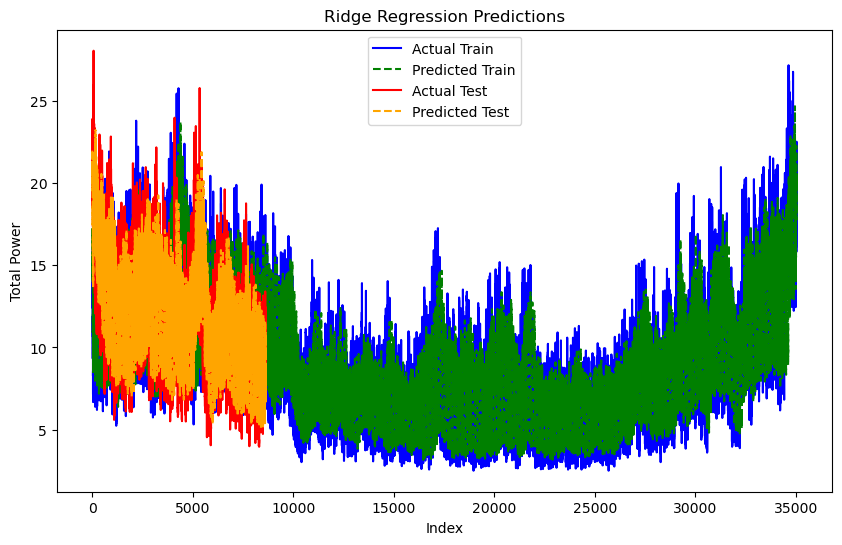

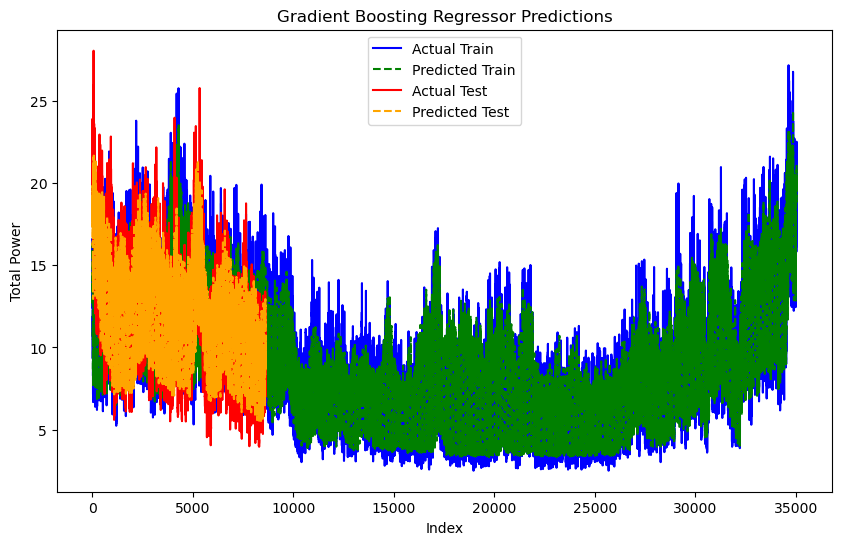

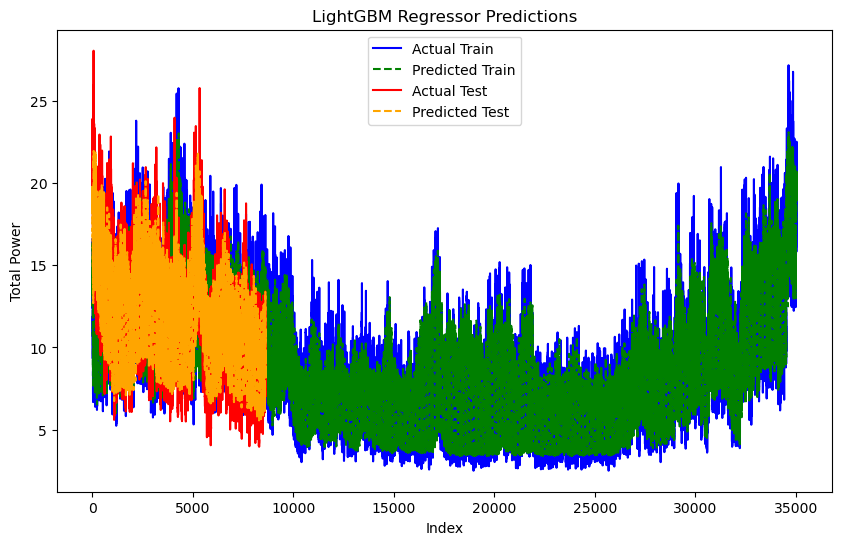

In [40]:
# Plot function
def plot_predictions(actual_train, pred_train, actual_test, pred_test, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_train, label='Actual Train', color='blue')
    plt.plot(pred_train, label='Predicted Train', linestyle='--', color='green')
    plt.plot(actual_test, label='Actual Test', color='red')
    plt.plot(pred_test, label='Predicted Test', linestyle='--', color='orange')
    plt.title(f'{model_name} Predictions')
    plt.xlabel('Index')
    plt.ylabel('Total Power')
    plt.legend()
    plt.show()
# Plotting for Ridge Regression
plot_predictions(y_train, ridge_train_pred_inverse, y_test, ridge_test_pred_inverse, 'Ridge Regression')

# Plotting for Gradient Boosting Regressor
plot_predictions(y_train, gbr_train_pred_inverse, y_test, gbr_test_pred_inverse, 'Gradient Boosting Regressor')

# Plotting for LightGBM Regressor
plot_predictions(y_train, lgbm_train_pred_inverse, y_test, lgbm_test_pred_inverse, 'LightGBM Regressor')


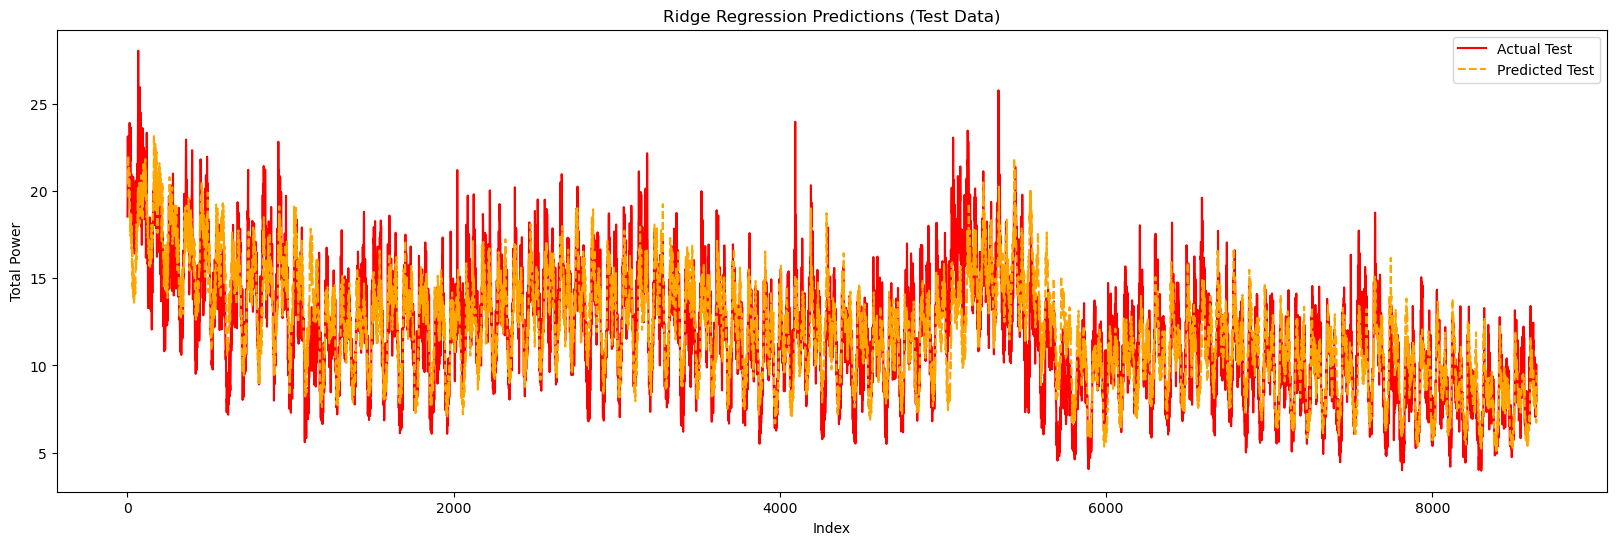

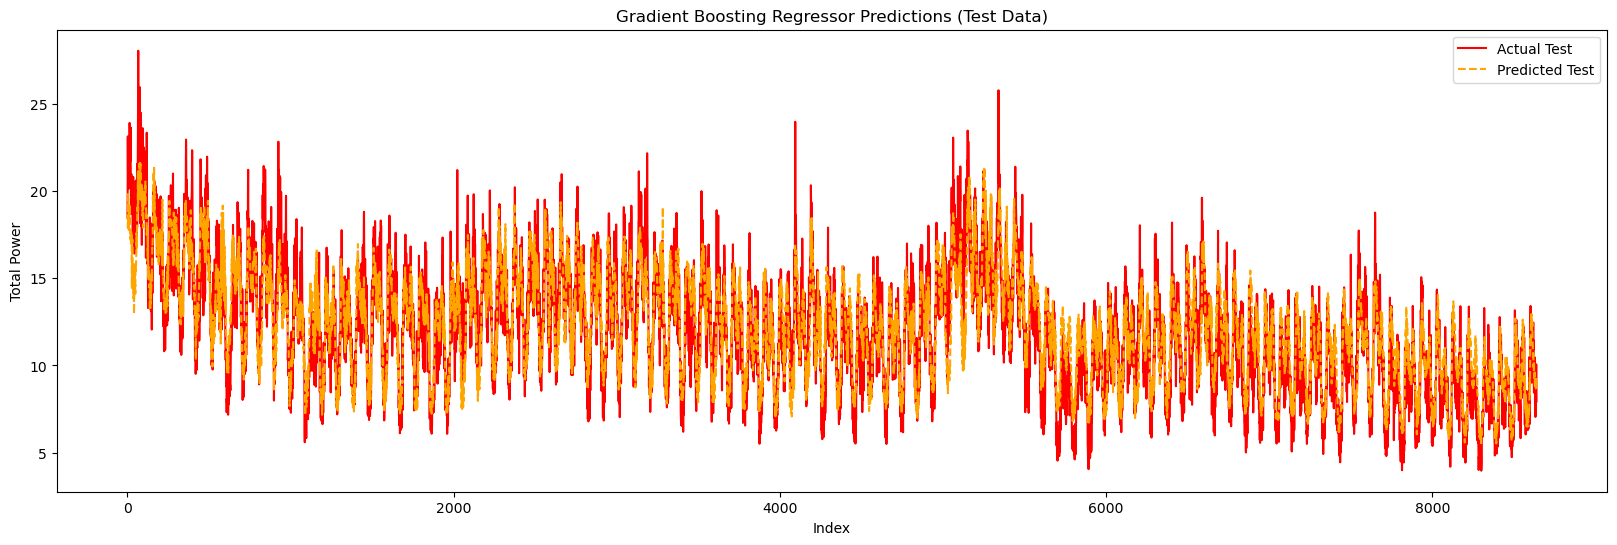

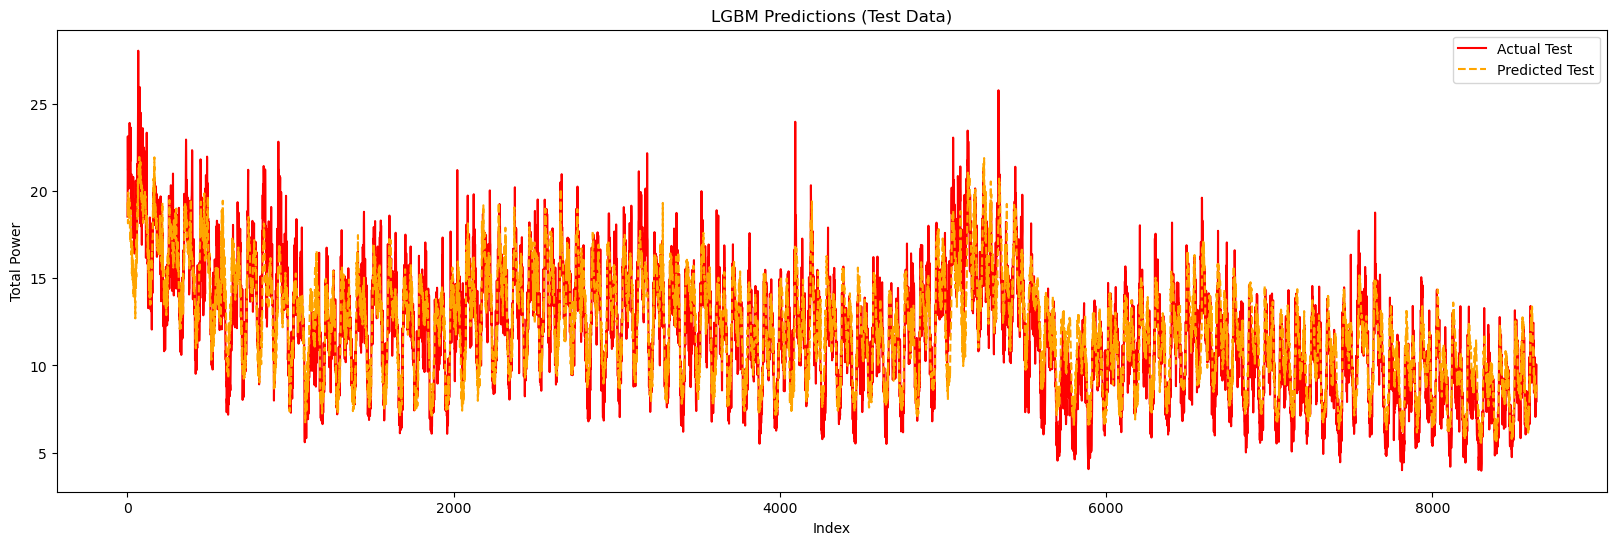

In [41]:
# Plot function for test data
def plot_test_predictions(actual_test, pred_test, model_name):
    plt.figure(figsize=(20, 6))
    plt.plot(actual_test, label='Actual Test', color='red')
    plt.plot(pred_test, label='Predicted Test', linestyle='--', color='orange')
    plt.title(f'{model_name} Predictions (Test Data)')
    plt.xlabel('Index')
    plt.ylabel('Total Power')
    plt.legend()
    plt.show()

# Plotting for Ridge Regression
plot_test_predictions(y_test, ridge_test_pred_inverse, 'Ridge Regression')

# Plotting for Gradient Boosting Regressor
plot_test_predictions(y_test, gbr_test_pred_inverse, 'Gradient Boosting Regressor')

# # Plotting for LightGBM Regressor
# plot_test_predictions(y_test, lgbm_pred_inverse, 'LightGBM Regressor')

# Plotting for LGBM
plot_test_predictions(y_test, lgbm_test_pred_inverse, 'LGBM')


In [23]:
# Ridge Regression Residuals
ridge_train_residuals = y_train - ridge_train_pred_inverse
ridge_test_residuals = y_test - ridge_test_pred_inverse

# LightGBM Residuals
lgbm_train_residuals = y_train - lgbm_train_pred_inverse
lgbm_test_residuals = y_test - lgbm_test_pred_inverse

# Gradient Boosting Regressor Residuals
gbr_train_residuals = y_train - gbr_train_pred_inverse
gbr_test_residuals = y_test - gbr_test_pred_inverse


In [24]:
# Convert Series to NumPy array before reshaping
residual_cluster_plot = pd.DataFrame(gbr_train_residuals.to_numpy().reshape(365, 96))
residual_cluster_plot["label"] = labels

# Compute standard deviation across time intervals for each cluster
stand_dev = {
    i: residual_cluster_plot.loc[residual_cluster_plot['label'] == i].iloc[:, :96].std()
    for i in range(4)
}

# # Plot
# sns.set(style="whitegrid")
# plt.figure(figsize=(12, 8))
# for key, value in stand_dev.items():
#     plt.plot(value.values, label=f'Cluster {key + 1}', linewidth=2)

# plt.title('Standard Deviation of Residuals for Different Clusters', fontsize=16)
# plt.xlabel('Time Interval (e.g., 15-min slots)', fontsize=14)
# plt.ylabel('Standard Deviation', fontsize=14)
# plt.xticks(
#     ticks=np.linspace(0, 95, 7),
#     labels=[f'{int(t*15)}m' for t in np.linspace(0, 95, 7)],
#     fontsize=12
# )
# plt.legend(title='Clusters', fontsize=12, title_fontsize=14)
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()


In [25]:
len(ridge_train_residuals)

35040

In [26]:
time_index = pd.date_range(start='2021-01-01 00:00:00', end='2021-12-31 23:45:00', freq='15T')

In [27]:
len(time_index)

35040

In [28]:
def rolling_mean(data, window_size):
    # Ensure the window size is a positive integer
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer")
    
    # Compute the rolling mean
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    rolling_mean = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    
    return rolling_mean

In [29]:
plot_df = pd.DataFrame({"total power":y_train, "residuals":ridge_train_residuals})
plot_df.index = time_index

In [30]:
plot_df['total power rolling mean'] = plot_df['total power'].rolling(window=100).mean()

<Axes: >

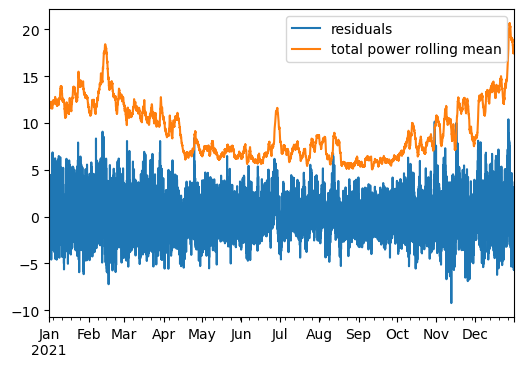

In [31]:
plot_df[["residuals","total power rolling mean"]].plot(figsize=(6, 4))

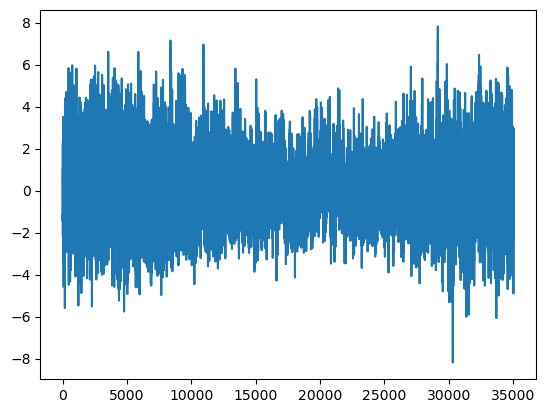

In [32]:
plt.plot(gbr_train_residuals)

In [33]:
ridge_residuals = np.array(ridge_train_residuals).reshape(365, 24, 4)
lgbm_residuals = np.array(lgbm_train_residuals).reshape(365, 24, 4)
gbr_residuals = np.array(gbr_train_residuals).reshape(365, 24,4)

ridge_residual_cluster = dict()

# Initialize a dictionary to store grouped data
ridge_residual_cluster = {label: [] for label in range(4)}
lgbm_residual_cluster = {label: [] for label in range(4)}
gbr_residual_cluster = {label: [] for label in range(4)}
# Group data based on label vector
for i, label in enumerate(labels):
    ridge_residual_cluster[label].append(ridge_residuals[i])
    lgbm_residual_cluster[label].append(lgbm_residuals[i])
    gbr_residual_cluster[label].append(gbr_residuals[i])

# # Convert lists to numpy arrays
# for label in grouped_data:
#     grouped_data[label] = np.array(grouped_data[label])

In [34]:
daily_test_y = np.array(y_test).reshape(90,96)
daily_ridge_test_y = ridge_test_pred_inverse.reshape(90,96)
daily_lgbm_test_y = lgbm_test_pred_inverse.reshape(90,96)
daily_gbr_test_y = gbr_test_pred_inverse.reshape(90,96)

## Find the closeness between predicted data and center of clusters

In [36]:
start = time.time()
daily_ridge_test_y_tensor = torch.tensor(daily_ridge_test_y, dtype=torch.float32)
label_prediction_ridge = spectralnet.predict(daily_ridge_test_y_tensor)
np.savetxt('label_prediction_ridge.csv', label_prediction_ridge, delimiter=',')
test_embeddings_ridge = spectralnet.embeddings_
np.savetxt('test_embeddings_ridge.csv', test_embeddings_ridge, delimiter=',')
_, closest_centroid_index = find_closest_centroid(test_embeddings_ridge[0], centers)
print(time.time()-start)

0.011137723922729492


In [37]:
### Dont run
start = time.time()

daily_gbr_test_y_tensor = torch.tensor(daily_gbr_test_y, dtype=torch.float32)
label_prediction_gbr = spectralnet.predict(daily_gbr_test_y_tensor)
np.savetxt('label_prediction_gbr.csv', label_prediction_gbr, delimiter=',')
test_embeddings_gbr = spectralnet.embeddings_
np.savetxt('test_embeddings_gbr.csv', test_embeddings_gbr, delimiter=',')
_, closest_centroid_index = find_closest_centroid(test_embeddings_ridge[0], centers)
print(time.time()-start)


0.01114034652709961


In [38]:
### Dont run
start = time.time()

daily_lgbm_test_y_tensor = torch.tensor(daily_lgbm_test_y, dtype=torch.float32)
label_prediction_lgbm = spectralnet.predict(daily_lgbm_test_y_tensor)
np.savetxt('label_prediction_lgbm.csv', label_prediction_lgbm, delimiter=',')
test_embeddings_lgbm = spectralnet.embeddings_
np.savetxt('test_embeddings_lgbm.csv', test_embeddings_lgbm, delimiter=',')
_, closest_centroid_index = find_closest_centroid(test_embeddings_ridge[0], centers)
print(time.time()-start)


0.014879226684570312


In [84]:
y_test_daily = np.array(y_test).reshape(90,96)

In [ ]:
# closest_centroid_index

In [ ]:
# ridge_residual_cluster[1][20][1], ridge_residual_cluster[1][2][1]

In [ ]:
# len(ridge_residual_cluster[0])

In [ ]:
# ridge_train_residuals

In [ ]:
# len(ridge_residual_cluster[0][0][0])

In [ ]:
# frequency[0]

In [ ]:
# closest_centroid_index

In [87]:
start =  time.time()
N = 1000
seed = 11
random.seed(seed)
ridge_residual_cluster_copy = ridge_residual_cluster.copy()
ridge_test_daily_predictions = ridge_test_pred_inverse.reshape(90,96)
ridge_test_residuals_daily = np.array(ridge_test_residuals).reshape(90,24,4)
simulation_df_ridge_dict = dict()
simulation_df_ridge = pd.DataFrame()
cluster_replacement_index = defaultdict(lambda: -1)

for day in range(90):
    _, closest_centroid_index = find_closest_centroid(test_embeddings_ridge[day], centers)
    simulation_df_ridge_dict[day] = pd.DataFrame([np.array([ridge_residual_cluster_copy[closest_centroid_index][random.randint(0, frequency[closest_centroid_index]-1)][i] 
               for i in range(24)]).flatten() 
                for j in range(N)]) + ridge_test_daily_predictions[day]
    simulation_df_ridge = pd.concat([simulation_df_ridge, simulation_df_ridge_dict[day]], axis = 1, ignore_index=True)
    cluster_replacement_index[closest_centroid_index] += 1
    ridge_residual_cluster_copy[closest_centroid_index][cluster_replacement_index[closest_centroid_index]] = ridge_test_residuals_daily[day]

print(time.time()-start)


3.421844482421875


In [88]:
############# Results saved for paper ###################
lin_res = pd.DataFrame(winkler_score_and_coverage(simulation_df_ridge, np.array(y_test), [85, 90, 95, 99, 99.9]))
lin_res.to_csv("lin_res.csv", index=False)
lin_res

,85.0,90.0,95.0,99.0,99.9
0,8.113701,8.840744,10.005725,10.944184,10.944403
1,0.811111,0.868750,0.923611,0.975926,0.975926


In [90]:
start =  time.time()
random.seed(seed)
lgbm_residual_cluster_copy = lgbm_residual_cluster.copy()
lgbm_test_daily_predictions = lgbm_test_pred_inverse.reshape(90, 96)
lgbm_test_residuals_daily = np.array(lgbm_test_residuals).reshape(90, 24, 4)
simulation_df_lgbm_dict = dict()
simulation_df_lgbm = pd.DataFrame()
cluster_replacement_index = defaultdict(lambda: -1)

for day in range(90):
    _, closest_centroid_index = find_closest_centroid(test_embeddings_lgbm[day], centers)
    
    simulation_df_lgbm_dict[day] = pd.DataFrame([
        np.array([
            lgbm_residual_cluster_copy[closest_centroid_index][random.randint(0, frequency[closest_centroid_index] - 1)][i] 
            for i in range(24)
        ]).flatten()
        for j in range(N)
    ]) + lgbm_test_daily_predictions[day]
    
    cluster_replacement_index[closest_centroid_index] += 1
    simulation_df_lgbm = pd.concat([simulation_df_lgbm, simulation_df_lgbm_dict[day]], axis=1, ignore_index=True)
    lgbm_residual_cluster_copy[closest_centroid_index][cluster_replacement_index[closest_centroid_index]] = lgbm_test_residuals_daily[day]
print(time.time()-start)


3.5924832820892334


In [91]:
lgbm_res = pd.DataFrame(winkler_score_and_coverage(simulation_df_lgbm, np.array(y_test), [85, 90, 95, 99, 99.9]))
lgbm_res = lgbm_res.round(3)
lgbm_res.to_csv("lgbm_res.csv", index=False)
lgbm_res

,85.0,90.0,95.0,99.0,99.9
0,8.059,8.930,10.345,12.500,12.872
1,0.790,0.833,0.910,0.976,0.976


In [40]:
start = time.time()
N = 1000
seed = 11
random.seed(seed)
gbr_residual_cluster_copy = gbr_residual_cluster.copy()
gbr_test_daily_predictions = gbr_test_pred_inverse.reshape(90,96)
gbr_test_residuals_daily = np.array(gbr_test_residuals).reshape(90,24,4)
simulation_df_gbr_dict = dict()
simulation_df_gbr = pd.DataFrame()
cluster_replacement_index = defaultdict(lambda: -1)

for day in range(90):
    _, closest_centroid_index = find_closest_centroid(test_embeddings_gbr[day], centers)
    simulation_df_gbr_dict[day] = pd.DataFrame([np.array([gbr_residual_cluster_copy[closest_centroid_index][random.randint(0, frequency[closest_centroid_index]-1)][i] 
               for i in range(24)]).flatten() 
                for j in range(N)]) + gbr_test_daily_predictions[day]
    
    cluster_replacement_index[closest_centroid_index] += 1
    simulation_df_gbr = pd.concat([simulation_df_gbr, simulation_df_gbr_dict[day]], axis = 1, ignore_index=True)
    gbr_residual_cluster_copy[closest_centroid_index][cluster_replacement_index[closest_centroid_index]] = gbr_test_residuals_daily[day]
print(time.time()-start)


3.826115846633911


In [94]:
############# Results saved for paper ################### 
gbr_res = pd.DataFrame(winkler_score_and_coverage(simulation_df_gbr, np.array(y_test), [85, 90, 95, 99, 99.9]))
gbr_res.to_csv("gbr_res.csv", index=False)
gbr_res

,85.0,90.0,95.0,99.0,99.9
0,6.962735,7.642592,8.579705,9.066994,9.079793
1,0.810116,0.867060,0.926898,0.982801,0.983148


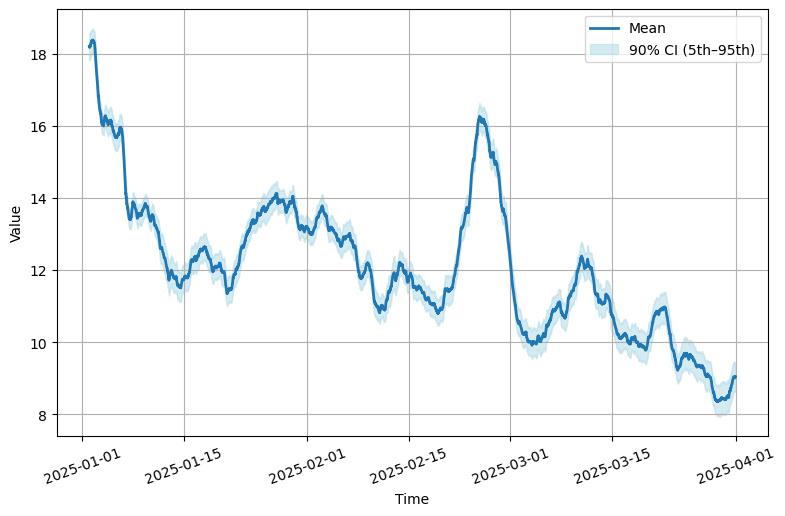

In [54]:
df = simulation_df_gbr
# Convert to time index (15‑minute intervals starting from Jan 1)
time_index = pd.date_range(start="2025-01-01", periods=8640, freq="15T")
df.columns = time_index

# Compute 1‑day moving average (1 day = 96 intervals of 15 minutes)
df_ma = df.rolling(window=96, axis=1).mean()
df_ma = df_ma.iloc[:, 95:]  # drop NaNs introduced by rolling

# Calculate statistics across simulations
median = df_ma.median(axis=0)
lower  = df_ma.quantile(0.05, axis=0)
upper  = df_ma.quantile(0.95, axis=0)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(median.index, median, label='Mean', linewidth=2)
plt.fill_between(median.index, lower, upper, color='lightblue', alpha=0.5, label='90% CI (5th–95th)')
#plt.title('1‑Day Moving Average: Mean and 90% Confidence Interval with CBB algorithm using GBR')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=20)
plt.grid(True)

# Save at 700 dpi
file_path = 'ci_gbr_cbb.png'
plt.savefig(file_path, dpi=700)
plt.show()